In [1]:
using PyPlot
using Random
using LsqFit
using FStrings
using DataFrames
using SpecialFunctions

In [2]:
P = zeros(50) .+ 0.30
P[1:10] = [0.5, 0.45, 0.45, 0.4, 0.4, 0.4, 0.35, 0.35, 0.35, 0.35];
#P = zeros(50) .+ 0.4; # FOR testing
#P = P .* (1 + 0.0256)
## Modify P Based on Level, ilvl, and tool
level = 85
ilvl = 85
tool = 0.0

X(n) = P[n+1]
S(N) = N > 0 ? prod(X.(collect(0:(N-1)))) : 1 - X(0)
Z(N) = N > 0 ? (1-X(N))*prod(X.(collect(0:(N-1)))) : 1-X(0)
T(N) = N + 1
# Finally, the thing we're after. Average time to target
TimeToTarget(N) = (sum( Z.(0:N-1) .* T.(0:N-1) ) + S(N)*T(N-1))/S(N)

TimeToTargetProt(N, pro) = pro < N ? TimeToTargetProt(N-1)*10 : TimeToTarget(N)

AvgExperience() = sum(S.(0:30) .* (0:30)) / sum(Z.(0:30).*T.(0:30))

## What else would we like? Average XP?
## Protection should be interesting, there is an infinite series of rapidly decreasing probability
## So we can use perterbation theory and take only Nth order terms. Start with N=1.

AvgExperience (generic function with 1 method)

In [8]:
## Simulated Values
function enhance(level; crit=0.0)
    if rand() < P[level+1]
        return rand() < crit ? level + 2 : level + 1
    end
    return 0
end

function simulatedEnhance(target; trials=10_000)
    dataset = []
    for t in collect(1:trials)
        count = 0
        level = 0
        while level < target
            count += 1
            level = enhance(level)
        end
        push!(dataset, count)
    end
    return sum(dataset)/length(dataset)
end

function protected(level, select; crit=0.0)
    if level < select
        return enhance(level; crit=crit)
    end
    if rand() < P[level+1]
        return rand() < crit ? level + 2 : level + 1
    end
    return max(0,level - 1)
end

mean(x) = sum(x) / length(x)
std(x) = sqrt(sum( (x .- mean(x)).^2 ) / length(x))

function simulatedProtected(target, select; trials=10_000, cost=60, crit=0.0)
    # Cost is ratio of protection cost over enhance cost
    dataset = []
    actionset = []
    protectionset = []
    for t in collect(1:trials)
        count = 0
        level = 0
        actions = 0
        protections = 0
        while level < target
            if level >= select
                count += cost+1
                protections += 1
            else
                count += 1
            end
            actions += 1
            level = protected(level, select; crit=crit)
        end
        push!(dataset, count)
        push!(actionset, actions)
        push!(protectionset, protections)
    end
    return [mean(dataset), mean(actionset), mean(protectionset)]
end

function simulatedProtectedNew(target, select; trials=10_000, cost=60, crit=0.0)
    # Cost is ratio of protection cost over enhance cost
    dataset = []
    actionset = []
    protectionset = []
    for t in collect(1:trials)
        count = 0
        level = 0
        actions = 0
        protections = 0
        while level < target
            count += 1
            actions += 1
            lastLevel = level
            level = protected(level, select; crit=crit)
            if (lastLevel >= select) && (lastLevel > level)
                count += cost
                protections += 1
            end
        end
        push!(dataset, count)
        push!(actionset, actions)
        push!(protectionset, protections)
    end
    return [mean(dataset), mean(actionset), mean(protectionset)]
end

function simOutcome(target, select; trials=10_000, cost=60, crit=0.0)
    # Cost is ratio of protection cost over enhance cost
    outcome = []
    results = []
    for t in collect(1:trials)
        count = 0
        level = 0
        actions = 0
        protections = 0
        while level < target
            if level >= select
                count += cost+1
                protections += 1
            else
                count += 1
            end
            actions += 1
            level = protected(level, select; crit=crit)
        end
        push!(outcome, level)
        push!(results, actions)
    end
    return outcome, results
end

function simulatedProtectedExp(select; trials=10_000, cost=60, bonus=0.0)
    dataset = []
    for t in collect(1:trials)
        experience = 0
        count = 0
        level = 0
        for t in collect(1:1000)
            #if level >= select
            #    count += cost+1
            #else
            #    count += 1
            #end
            count += 1
            lastLevel = level
            level = protected(level, select)
            if level > lastLevel
                experience += level
            else
                experience += (lastLevel+1)*bonus
                if lastLevel >= select
                    count += cost
                end
            end
        end
        push!(dataset, experience/count)
    end
    return sum(dataset)/length(dataset)
end

function fastSim(target, select; trials=10_000)
    dataset = []
    if target <= select
        return TimeToTarget(target)
    end
    for t in collect(1:trials)
        count = TimeToTarget(select)
        level = select
        while level < target
            level = protected(level, select)
            if level < select - 1
                # Reset and boost count
                count += TimeToTarget(select) + 1
                level = select
            else
                count += 1
            end
        end
        push!(dataset, count)
    end
    return sum(dataset)/length(dataset)
end

function simulatedAlpha(target; trials=10_000)
    dataset = []
    for t in collect(1:trials)
        resets = 0
        level = 0
        while level < target
            if( level == 0 )
                resets += 1
            end
            level = enhance(level)
        end
        push!(dataset, resets)
    end
    return sum(dataset)/length(dataset)
end

function f(ρ)
    Q = (1-ρ)^2 .+ ρ*(1-ρ).*(1 .- circshift(P,-1)) .+ ρ./P
    Q[1] = 1
    cumprod(Q)
end

f (generic function with 1 method)

In [11]:
x = collect(0:14)
# Cost, Actions, Protections
#reg = simulatedProtected.(x, 6; trials=100_000, cost=30)
Old = simulatedProtected.(x, 5; trials=100_000, cost=30, crit=0.01)
New = simulatedProtectedNew.(x, 5; trials=100_000, cost=30, crit=0.01)
@show Old New

Old = [[0.0, 0.0, 0.0], [2.00619, 2.00619, 0.0], [6.54787, 6.54787, 0.0], [16.64155, 16.64155, 0.0], [43.27692, 43.27692, 0.0], [109.25619, 109.25619, 0.0], [282.70027, 209.25157, 2.44829], [683.63304, 392.99664, 9.68788], [1505.10278, 734.77688, 25.67753], [3067.99742, 1350.32492, 57.25575], [6039.88694, 2490.03404, 118.32843], [12930.85428, 5102.70978, 260.93815], [28705.82192, 11033.93702, 589.06283], [64847.12879, 24606.45269, 1341.35587], [147102.03283, 55441.52923, 3055.35012]]
New = [[0.0, 0.0, 0.0], [1.99749, 1.99749, 0.0], [6.54466, 6.54466, 0.0], [16.57026, 16.57026, 0.0], [43.14282, 43.14282, 0.0], [108.77581, 108.77581, 0.0], [252.69588, 208.90788, 1.4596], [571.20528, 393.33258, 5.92909], [1211.45421, 733.28871, 15.93885], [2431.91961, 1355.54661, 35.8791], [4715.79257, 2492.65577, 74.10456], [9988.90294, 5083.84234, 163.50202], [22126.49739, 11022.45789, 370.13465], [49564.87416, 24409.97076, 838.49678], [112743.519, 55216.1607, 1917.57861]]


15-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0]
 [1.99749, 1.99749, 0.0]
 [6.54466, 6.54466, 0.0]
 [16.57026, 16.57026, 0.0]
 [43.14282, 43.14282, 0.0]
 [108.77581, 108.77581, 0.0]
 [252.69588, 208.90788, 1.4596]
 [571.20528, 393.33258, 5.92909]
 [1211.45421, 733.28871, 15.93885]
 [2431.91961, 1355.54661, 35.8791]
 [4715.79257, 2492.65577, 74.10456]
 [9988.90294, 5083.84234, 163.50202]
 [22126.49739, 11022.45789, 370.13465]
 [49564.87416, 24409.97076, 838.49678]
 [112743.519, 55216.1607, 1917.57861]

fracPlt = regPlt ./ critPlt = [NaN, 1.0026672683061342, 1.0117801544444966, 1.0275546333032102, 1.0422355240241767, 1.0479486572672616, 1.0727041061863958, 1.087638341645498, 1.097993858746896]


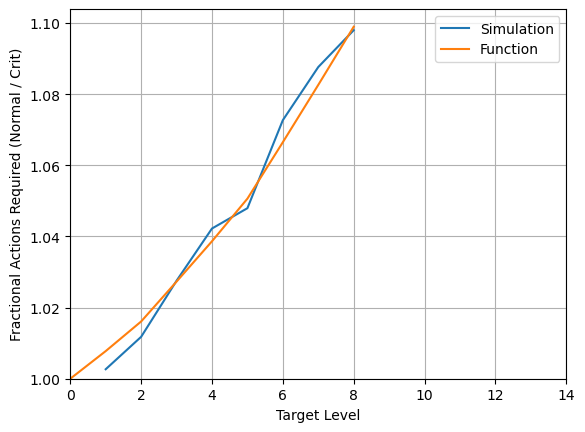

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/morgan/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


PyObject <matplotlib.legend.Legend object at 0x7ffa2869ebc0>

In [5]:
clmn(x, n) = reduce(hcat,x)'[:,n]

regPlt = clmn(reg, 2)
critPlt = clmn(crit, 2)
@show fracPlt = regPlt ./ critPlt
#plt.plot(x, (1.015).^(x.-1))
plt.plot(x, fracPlt, label="Simulation")
plt.plot(x, f(0.01)[x.+1], label="Function")
plt.ylim(bottom=1)
plt.xlim(0, 14)
plt.xlabel("Target Level")
plt.ylabel("Fractional Actions Required (Normal / Crit)")
plt.grid()
plt.legend()

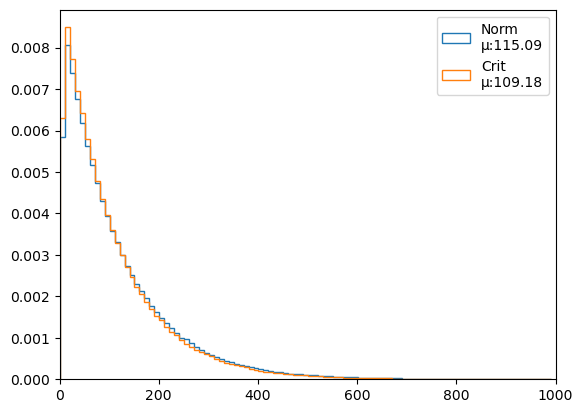

PyObject <matplotlib.legend.Legend object at 0x7ffa28659120>

In [6]:
bins = collect(1:10:1000)
y = simOutcome(5, 60; crit=0.0, trials=1_000_000)[2]
q = simOutcome(5, 60; crit=0.01, trials=1_000_000)[2]
plt.hist(y,histtype="step", label=f"Norm\nμ:{mean(y):0.2f}", bins=bins, density=true);
plt.hist(q,histtype="step", label=f"Crit\nμ:{mean(q):0.2f}", bins=bins, density=true);
plt.xlim(0, 1000)
plt.legend()

μ = mean(data) = 2510.1724
std(data) = 

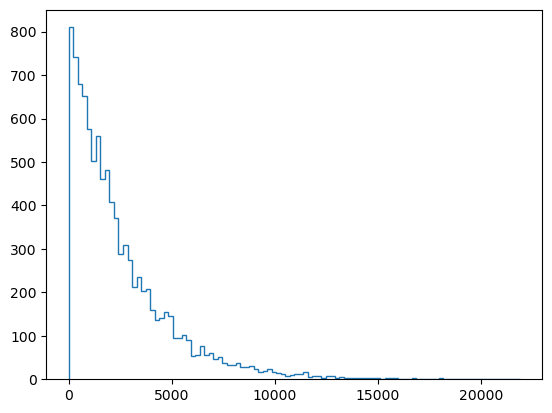

2478.02346180948


([810.0, 742.0, 679.0, 651.0, 575.0, 502.0, 560.0, 462.0, 482.0, 407.0  …  1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [10.0, 228.66, 447.32, 665.98, 884.64, 1103.3, 1321.96, 1540.62, 1759.28, 1977.94  …  19908.06, 20126.72, 20345.38, 20564.04, 20782.7, 21001.36, 21220.02, 21438.68, 21657.34, 21876.0], PyCall.PyObject[PyObject <matplotlib.patches.Polygon object at 0x7ffa31ff6e00>])

In [7]:
## Variance
data = simOutcome(10, 5; crit=0.01, cost=20.0)[2]
@show μ = mean(data)
@show std(data)
plt.hist(data, histtype="step", bins=100)

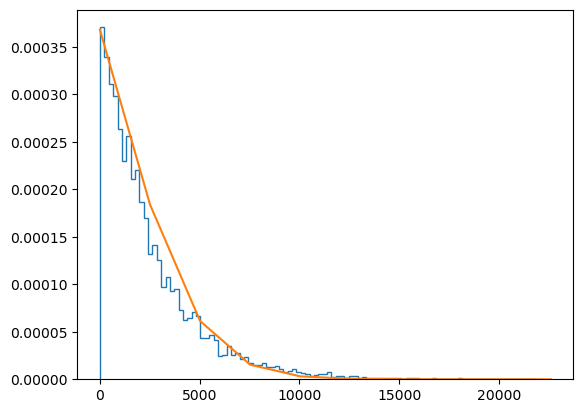

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff9f1b92e00>

In [8]:
y, x, _ = plt.hist(data, histtype="step", bins=100, density=true)
#plt.plot(x, λ.^x .* exp.(-λ) ./ gamma.(x .+ 1) )
λ = 1
cx = 1:10
plt.plot( (cx .- 1).*μ, λ.^(cx) .* exp.(-λ) ./ gamma.( cx .+ 1 ) /1000 )

In [9]:
# Relative Error of the above
plt.plot(x, fracPlt./(f(0.01)[x.+1]), label=f"hello {1.233232:0.2f}")
plt.legend()

LoadError: BoundsError: attempt to access 50-element Vector{Float64} at index [[11.0, 229.66, 448.32, 666.98, 885.64, 1104.3, 1322.96, 1541.62, 1760.28, 1978.94  …  19909.06, 20127.72, 20346.38, 20565.04, 20783.7, 21002.36, 21221.02, 21439.68, 21658.34, 21877.0]]

In [10]:
AvgExperience() = sum(S.(0:30) .* (0:30)) / sum(Z.(0:30).*T.(0:30))
AB() = ( sum( S.(0:30) .* (0:30) .+ Z.(0:30) .* (1:31) .* 0.1 ) )/ sum( Z.(0:30) .* T.(0:30) ) 
@show simulatedProtectedExp(50) AvgExperience()
@show simulatedProtectedExp(50;bonus=0.1) AB()

simulatedProtectedExp(50) = 0.8242747000000001
AvgExperience() = 0.8250824156958845
simulatedProtectedExp(50; bonus = 0.1) = 0.924613110000005
AB() = 0.9250824156958845


0.9250824156958845